**20L-0961**

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [32]:

df = pd.read_excel('OnlineRetail.xlsx')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [33]:
print(df.shape)
df.info()
df.describe()

(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [34]:
df.dropna(inplace=True)
print(df.isnull().sum())
print(df.shape)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
(406829, 8)


In [35]:
df.CustomerID = df.CustomerID.astype(int)
# add new attr for total amount
df['TotalMonetary'] = df['Quantity'] * df['UnitPrice']

# RFM Analysis
# monetary
monetary = df.groupby('CustomerID')['TotalMonetary'].sum()
monetary = monetary.reset_index()
monetary

,CustomerID,TotalMonetary
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40
...,...,...
4367,18280,180.60
4368,18281,80.82
4369,18282,176.60
4370,18283,2094.88


In [36]:
# frequency
frequency = df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'Frequency']
frequency

,CustomerID,Frequency
0,12346,2
1,12347,182
2,12348,31
3,12349,73
4,12350,17
...,...,...
4367,18280,10
4368,18281,7
4369,18282,13
4370,18283,756


In [37]:
# merge the two dfs
rmf = monetary.merge(frequency, on='CustomerID', how='inner')
rmf

,CustomerID,TotalMonetary,Frequency
0,12346,0.00,2
1,12347,4310.00,182
2,12348,1797.24,31
3,12349,1757.55,73
4,12350,334.40,17
...,...,...,...
4367,18280,180.60,10
4368,18281,80.82,7
4369,18282,176.60,13
4370,18283,2094.88,756


In [38]:
# recency
df.InvoiceDate = pd.to_datetime(df.InvoiceDate, format='%Y-%m-%d %H:%M:%S')
max_date = max(df.InvoiceDate)
df['Diff'] = max_date - df.InvoiceDate
recency = df.groupby('CustomerID')['Diff'].min()
recency = recency.reset_index()
recency

,CustomerID,Diff
0,12346,325 days 02:33:00
1,12347,1 days 20:58:00
2,12348,74 days 23:37:00
3,12349,18 days 02:59:00
4,12350,309 days 20:49:00
...,...,...
4367,18280,277 days 02:58:00
4368,18281,180 days 01:57:00
4369,18282,7 days 01:07:00
4370,18283,3 days 00:48:00


In [39]:
# set diff to days only
recency['Diff'] = recency['Diff'].dt.days
rfm = rmf.merge(recency, on='CustomerID', how='inner')
rfm.columns = ['CustomerID','Monetary', 'Frequency', 'Recency']
rfm

,CustomerID,Monetary,Frequency,Recency
0,12346,0.00,2,325
1,12347,4310.00,182,1
2,12348,1797.24,31,74
3,12349,1757.55,73,18
4,12350,334.40,17,309
...,...,...,...,...
4367,18280,180.60,10,277
4368,18281,80.82,7,180
4369,18282,176.60,13,7
4370,18283,2094.88,756,3


In [40]:
# # Removing (statistical) outliers for Monetary
Q1 = rfm.Monetary.quantile(0.05)
Q3 = rfm.Monetary.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [41]:
# rescaling
rfm_norm1 = rfm.drop('CustomerID', axis=1)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_norm1)
rfm_scaled = pd.DataFrame(rfm_scaled, columns=rfm_norm1.columns)

In [42]:
rfm_scaled

,Monetary,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188
...,...,...,...
4288,-0.624669,-0.683068,-0.193560
4289,-0.620853,-0.673094,1.826341
4290,-0.677696,-0.703017,0.865898
4291,-0.623131,-0.643171,-0.847057


In [43]:
km = KMeans(n_clusters=4, random_state=0).fit(rfm_scaled)
km

KMeans(n_clusters=4, random_state=0)

In [44]:
km.labels_

array([1, 0, 2, ..., 1, 2, 2])

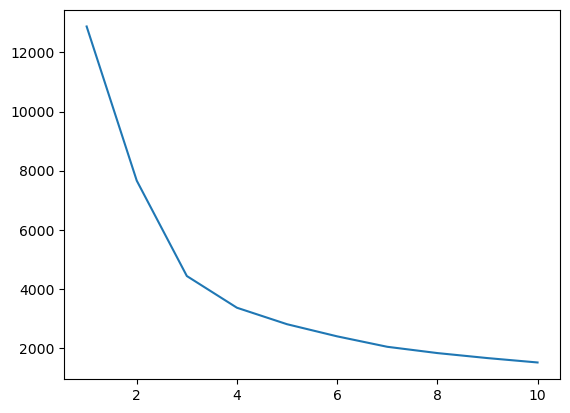

In [45]:
# find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)

In [46]:
import warnings
warnings.filterwarnings('ignore')

# silhouette scores
n_clusters = range(2, 11)

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=0)
    cluster_labels = kmeans.fit_predict(rfm_scaled)
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    print(f"For n_clusters={n}, the silhouette score is {silhouette_avg}")

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.48185520134959714
For n_clusters=5, the silhouette score is 0.46627005641897035
For n_clusters=6, the silhouette score is 0.41758431193450735
For n_clusters=7, the silhouette score is 0.41707632727623195
For n_clusters=8, the silhouette score is 0.4099550565243077
For n_clusters=9, the silhouette score is 0.3723618210202064
For n_clusters=10, the silhouette score is 0.3408702872730963


In [47]:
# with cluster 3
kmeans = KMeans(n_clusters=3, random_state=0).fit(rfm_scaled)
rfm['Cluster'] = kmeans.labels_
rfm

,CustomerID,Monetary,Frequency,Recency,Cluster
0,12346,0.00,2,325,2
1,12347,4310.00,182,1,0
2,12348,1797.24,31,74,1
3,12349,1757.55,73,18,1
4,12350,334.40,17,309,2
...,...,...,...,...,...
4366,18278,173.90,9,73,1
4367,18280,180.60,10,277,2
4368,18281,80.82,7,180,2
4369,18282,176.60,13,7,1


<Axes: xlabel='Frequency', ylabel='Monetary'>

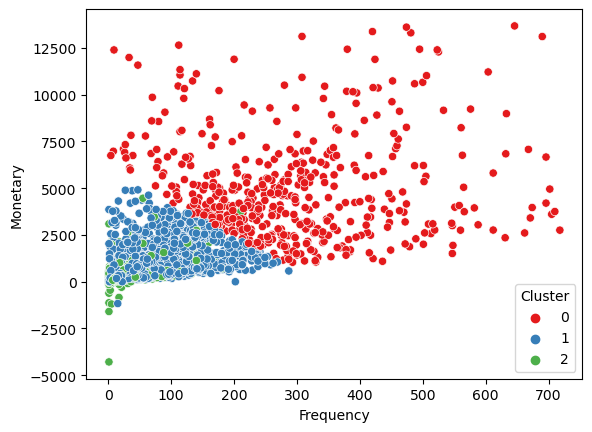

In [48]:
# visualize the clusters
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfm, palette='Set1')

<Axes: xlabel='Cluster', ylabel='Monetary'>

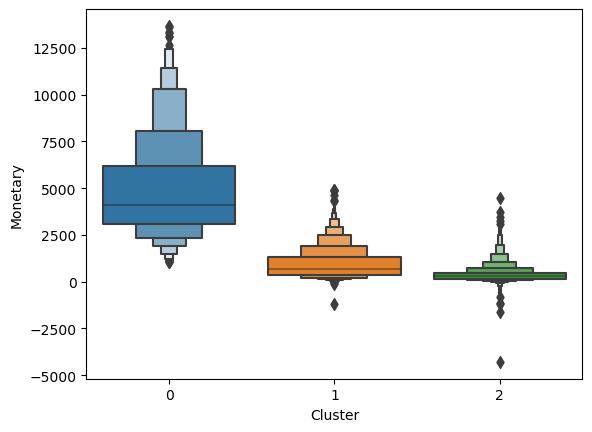

In [18]:
sns.boxenplot(x='Cluster', y='Monetary', data=rfm)

<Axes: xlabel='Cluster', ylabel='Frequency'>

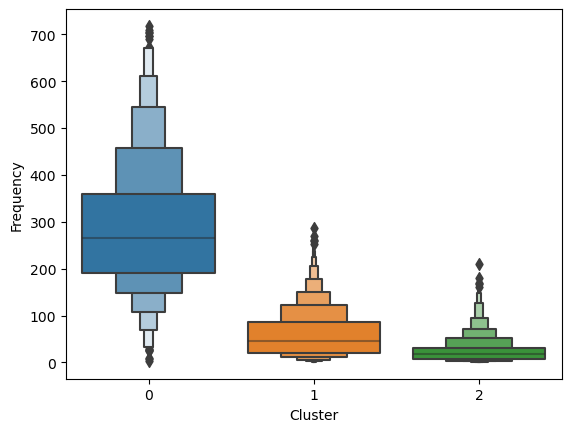

In [19]:
sns.boxenplot(x='Cluster', y='Frequency', data=rfm)

<Axes: xlabel='Cluster', ylabel='Recency'>

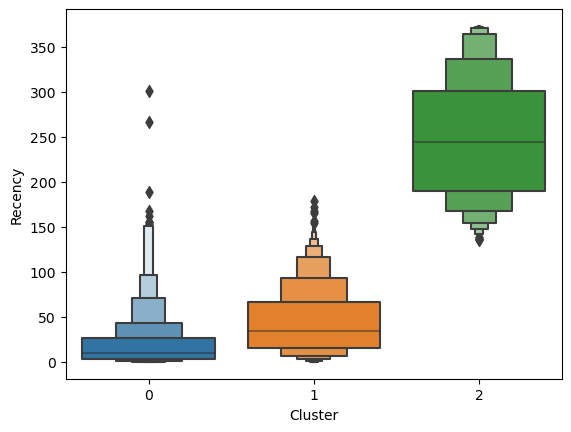

In [20]:
sns.boxenplot(x='Cluster', y='Recency', data=rfm)   

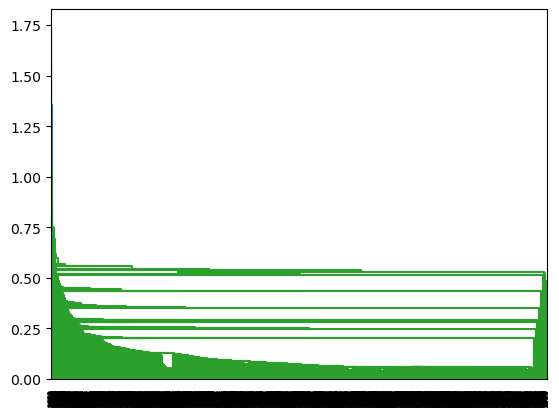

In [21]:
# single linkage hierarchical clustering
mergings = linkage(rfm_scaled, method='single', metric='euclidean')
dendrogram(mergings)
plt.show()

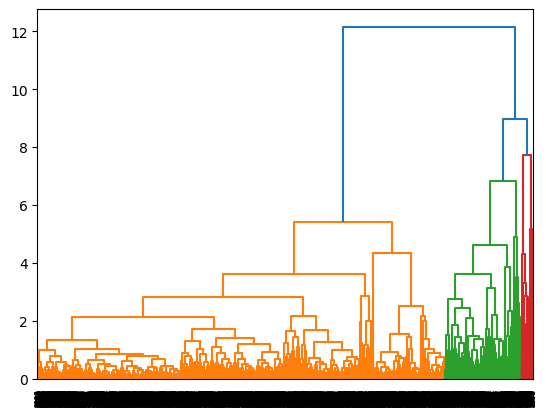

In [22]:
# complete linkage hierarchical clustering
mergings = linkage(rfm_scaled, method='complete', metric='euclidean')
dendrogram(mergings)
plt.show()

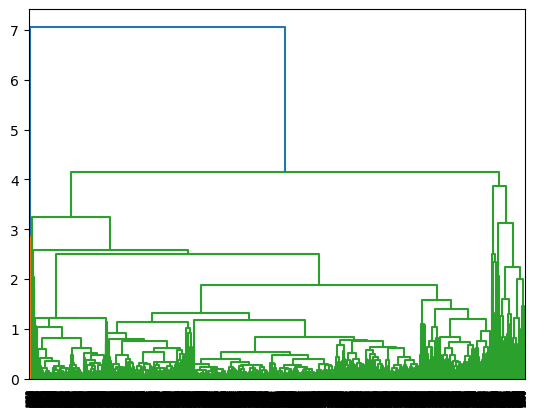

In [23]:
# average linkage hierarchical clustering

mergings = linkage(rfm_scaled, method='average', metric='euclidean')
dendrogram(mergings)
plt.show()

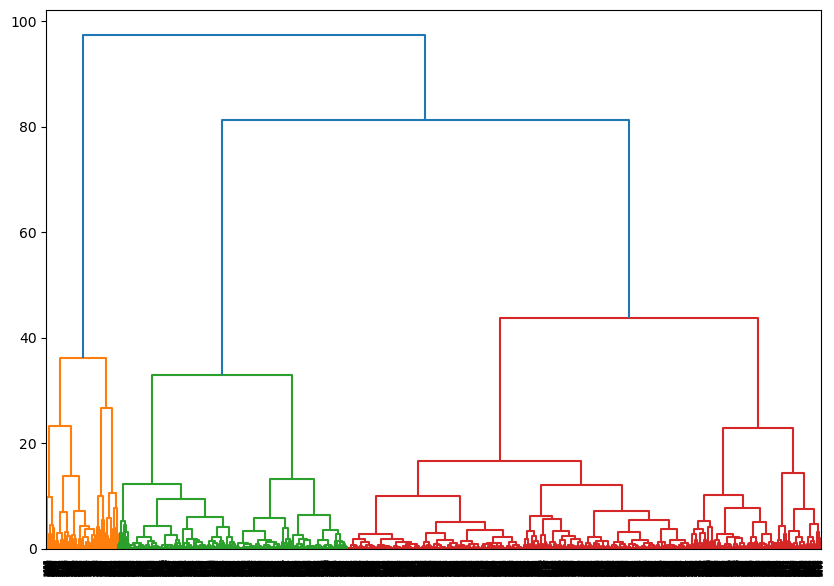

In [24]:
# Agglomertive visualization
plt.figure(figsize=(10, 7))
dendrogram(linkage(rfm_scaled, method='ward'))
plt.show()

In [25]:
# silhouette score
n_clusters = range(2, 11)
for n in n_clusters:
    cluster_labels = AgglomerativeClustering(n_clusters=n,affinity='euclidean', linkage='ward').fit_predict(rfm_scaled)
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    print(f"For n_clusters={n}, the silhouette score is {silhouette_avg}")

For n_clusters=2, the silhouette score is 0.5788705653522203
For n_clusters=3, the silhouette score is 0.4643083907731691
For n_clusters=4, the silhouette score is 0.4051843429630831
For n_clusters=5, the silhouette score is 0.4151126610727816
For n_clusters=6, the silhouette score is 0.39121274591666594
For n_clusters=7, the silhouette score is 0.39450185476960764
For n_clusters=8, the silhouette score is 0.3979142340528074
For n_clusters=9, the silhouette score is 0.3984928308178272
For n_clusters=10, the silhouette score is 0.3084458194010934


In [49]:
# cutting the dendrogram
clusters = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward').fit_predict(rfm_scaled)
rfm['Cluster'] = clusters
rfm

,CustomerID,Monetary,Frequency,Recency,Cluster
0,12346,0.00,2,325,2
1,12347,4310.00,182,1,1
2,12348,1797.24,31,74,0
3,12349,1757.55,73,18,0
4,12350,334.40,17,309,2
...,...,...,...,...,...
4366,18278,173.90,9,73,0
4367,18280,180.60,10,277,2
4368,18281,80.82,7,180,2
4369,18282,176.60,13,7,0


<Axes: xlabel='Frequency', ylabel='Monetary'>

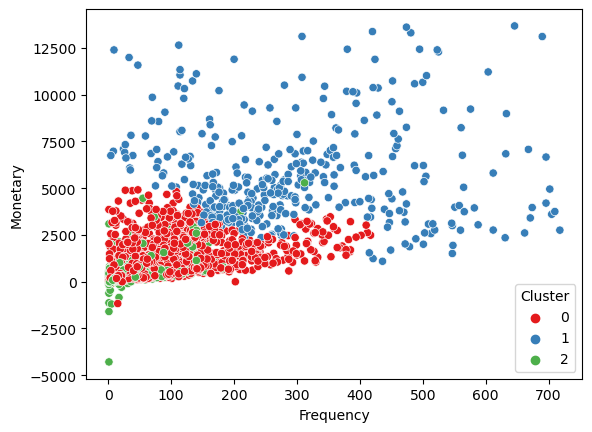

In [50]:
# show plot for clusters
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfm, palette='Set1')

<Axes: xlabel='Cluster', ylabel='Monetary'>

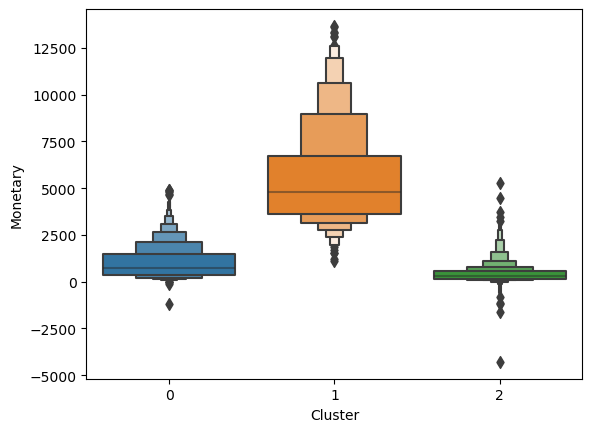

In [27]:
# cluster vs monetary
sns.boxenplot(x='Cluster', y='Monetary', data=rfm)

<Axes: xlabel='Cluster', ylabel='Frequency'>

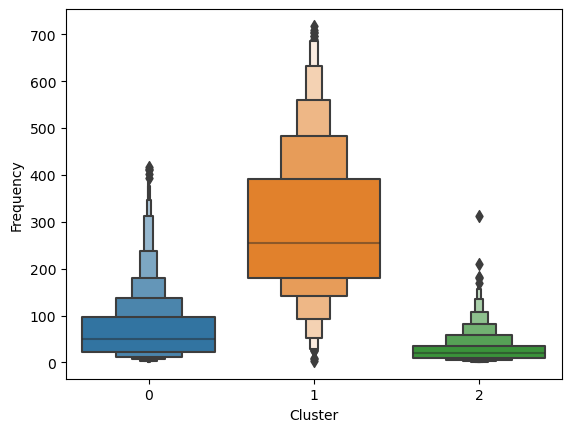

In [28]:
# cluster vs frequency
sns.boxenplot(x='Cluster', y='Frequency', data=rfm)

<Axes: xlabel='Cluster', ylabel='Recency'>

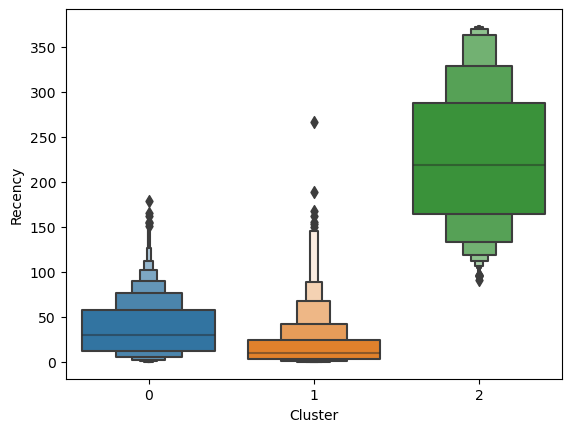

In [29]:
# cluster vs recency
sns.boxenplot(x='Cluster', y='Recency', data=rfm)

> **Final Analysis**

# Problem Statement
Explain which algorithm is better, the one used in Problem 1 or Problem 2, and why? You claim
must be supported by stats and facts showcased in your code.
# Solution

   Hierarchical clustering has higher silhouette score than K-means clustering for all assigned clusters.
   This means that Hierarchical clustering is doing a better job in assigning the data points to the clusters, such that the data points are closer to their own cluster than to other clusters.
   For example, for n_clusters=2, the silhouette score for Hierarchical Clustering is 0.5788705653522203, while for KMeans it is 0.5415858652525395. This trend continues for all numbers of clusters. Hierarchical Clustering also has better score at max clusters given in the code.
   

Therefore, based on my silhouette scores, the Hierarchical Clustering algorithm is performing better than the KMeans algorithm for this particular dataset.